### Sample Efficiency

This notebook contains the code to reproduce the sample efficiency experiments in the paper.
The full notebook takes around 40 minutes to an hour to run. Start by importing the methods and create a wrapper for finding the correct sample size at a given error level and variance.

In [1]:
import numpy as np
from jax import jit
from jax import numpy as jnp
import matplotlib.pyplot as plt
from em import em
from mca import mca
from bsi import bsi
from data import get_samples, get_signal
from utils import align_to_signal, relative_error, bisection_search
from jax.random import PRNGKey, normal

@jit
def oracle(y, std, shifts): return jnp.roll(y, -shifts, axis=1).mean(axis=0)
    
def run_method_to_eps(key, x, N0, N1, std, eps, method, **methodargs):
    def method_wrapper(N):
        y, noise, shift = get_samples(key, x, std, N)
        if method == "oracle":
            methodargs["shifts"] = shift
            return relative_error(x, oracle(y, std, shift))
        return relative_error(x, align_to_signal(method(y, std, **methodargs), x))
    
    N, val, info = bisection_search(method_wrapper, eps, N0, N1, bitol=2, verbose=True)
    return N, val, info

Next, generate synthetic data and define variables.

In [2]:

# Main parameters
L = 41
t, x = get_signal(L)
x0 = normal(PRNGKey(0), (L,))

# Parameters for the experiment
num_samples = np.logspace(1, 4, 10, dtype=int)
noise_stds = np.logspace(-3, 1, 40, dtype=float)[::-1]
eps_vals = [1. , 1e-1, 1e-2, 1e-3]
methods = ["oracle", em, mca, bsi]
names = ["oracle", "EM", "MCA", "BSI"]
methodargs = [{}, {"x0":x0}, {"x0":x0}, {}]
data = {name: [] for name in names}


I0000 00:00:1725627067.018847  130070 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Run the bisection search for sample size. This code takes around 40 minutes to run.

In [3]:
import os

for name, method, kwargs in zip(names, methods, methodargs):
    print(f"################ Running {name} ###################")
    for eps in eps_vals:
        N0 = 2
        N1 = 1000
        for std in noise_stds:
            print(f"Finding N in ({N0}, {N1}) so that {name} is accurate to eps={eps}, std={std}")
            N, err, info = run_method_to_eps(PRNGKey(0), x, N0, N1, std, eps, method, **kwargs)
            data[name].append((eps, std, err, N))
            # If the method converged, update the search interval
            if info == 0:
                N1 = N
    data[name] = np.array(data[name])
    datapath = os.path.join(os.getcwd(), f"/data/data_{name}.npy")
    np.save(datapath, data[name])
    


################ Running oracle ###################
Finding N in (2, 1000) so that oracle is accurate to eps=1.0, std=10.0


2024-09-06 14:53:34.217444: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_oracle] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-09-06 14:56:28.470637: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m54.254419118s

********************************
[Compiling module jit_oracle] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Finding N in (2, 12) so that oracle is accurate to eps=1.0, std=7.896522868499725
Finding N in (2, 12) so that oracle is accurate to eps=1.0, std=6.235507341273912
Finding N in (2, 4) so that oracle is accurate to eps=1.0, std=4.923882631706737
Finding N in (2, 3) so that oracle is accurate to eps=1.0, std=3.888155180308085
Finding N in (2, 3) so that oracle is accurate to eps=1.0, std=3.07029062975785
Finding N in (2, 3) so that oracle is accurate to eps=1.0, std=2.424462017082328
Finding N in (2, 3) so that oracle is accurate to eps=1.0, std=1.9144819761699576
Finding N in (2, 3) so that oracle is accurate to eps=1.0, std=1.5117750706156616
Finding N in (2, 3) so that oracle is accurate to eps=1.0, std=1.1937766417144358
Finding N in (2, 3) so that oracle is accurate to eps=1.0, std=0.9426684551178854
Finding N in (2, 3) so that oracle is accurate to eps=1.0, std=0.7443803013251689
Finding N in (2, 3) so that oracle is accurate to eps=1.0, std=0.5878016072274912
Finding N in (2, 3) s

Plot the results. You might have to change the y-limits according to the results you obtained.

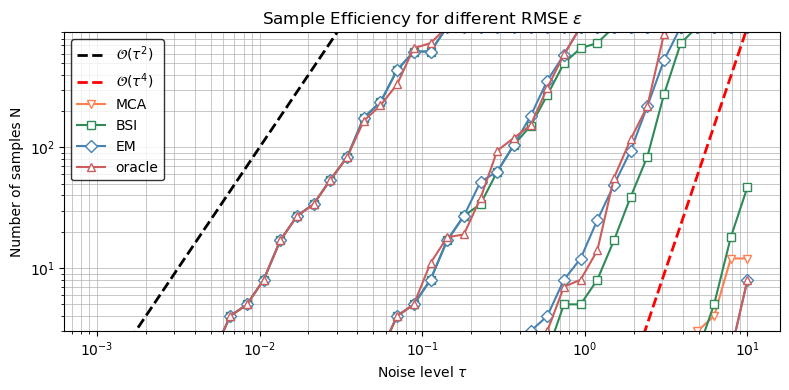

In [6]:
colors = ["coral", "seagreen", "steelblue", "indianred"]
displaynames = ["MCA", "BSI", "EM", "oracle"]
styles = ["-v", "-s", "-D", "-^"]

fig = plt.figure(figsize=(8, 4))

# Plot O(tau^2) and O(tau^4) lines
sigma_list = np.logspace(-3, 1, 100)
coefs = [1e6, 0.1]
exp_list = [2, 4]
for i in range(2):
    plt.plot(sigma_list, coefs[i]*sigma_list**exp_list[i], 'k--' if i == 0 else 'r--', linewidth=2, label="$\\mathcal{O}(\\tau^"+f"{exp_list[i]}"+")$")

# Plot data
data = {}
for method, displayname, color, style in zip(names, displaynames, colors, styles):
    datapath = os.path.join(os.getcwd(), f"/data/data_{method}.npy")
    data[method] = np.load(datapath, allow_pickle=True)
    for eps in eps_vals:
        data[method] = np.array(data[method])
        idx = (data[method][:, 0] == eps)#*(data[method][:, 3] > 2)#*(data[method][:, 3] < 30000)
        x = data[method][idx, 1]
        y = data[method][idx, 3]
        plt.plot(x, y, style, color=color, label=f"{displayname}" if eps==1.0 else "",  markerfacecolor='white')


plt.grid(True, which='both', linewidth=0.5)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Number of samples N")
plt.xlabel("Noise level $\\tau$")
plt.legend().set_title("Method")
plt.legend().get_frame().set_boxstyle('square')
plt.legend().get_frame().set_linewidth(0.5)
plt.legend().get_frame().set_edgecolor('black')
plt.title("Sample Efficiency for different RMSE $\epsilon$")
plt.ylim(3, 900)
plt.tight_layout()